In [2]:
from fastai.tabular.all import *

In [5]:
df=pd.read_csv('titanic/train.csv')

In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
def add_feature(df):
    df['LogFare']=np.log1p(df['Fare'])
    df['Title']=df.Name.str.split(', ',expand=True)[1].str.split('.',expand=True)[0]
    df['Title']=df['Title'].map(dict(Mr="Mr",Miss='Miss',Mrs='Mrs',Master='Master'))
    df['TicketFreq']=df.groupby('Ticket')['Ticket'].transform('count')
    df['Deck']=df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family']=df.SibSp+df.Parch
    df['Alone']=df.Family==0
add_feature(df)
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Title,TicketFreq,Deck,Family,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2.110213,Mr,1,NaN,1,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593,Mrs,1,ABC,1,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2.188856,Miss,1,NaN,0,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834,Mrs,2,ABC,1,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,2.202765,Mr,1,NaN,0,True


In [29]:
splits=RandomSplitter(seed=42)(df)

In [30]:
print(splits)

([788, 525, 821, 253, 374, 98, 215, 313, 281, 305, 701, 812, 76, 50, 387, 47, 516, 564, 434, 117, 150, 513, 676, 470, 569, 603, 816, 719, 120, 88, 204, 617, 615, 61, 648, 139, 840, 831, 302, 118, 58, 257, 404, 24, 618, 730, 371, 104, 370, 592, 548, 633, 216, 682, 157, 103, 512, 574, 650, 312, 757, 225, 241, 557, 808, 827, 334, 208, 23, 2, 28, 319, 463, 77, 34, 637, 842, 30, 460, 888, 217, 405, 10, 66, 852, 291, 249, 872, 75, 450, 597, 377, 178, 207, 737, 318, 573, 64, 415, 220, 184, 49, 384, 97, 121, 111, 568, 873, 343, 495, 611, 712, 723, 829, 871, 29, 641, 69, 844, 383, 560, 394, 817, 643, 820, 832, 409, 645, 441, 732, 636, 848, 475, 317, 884, 881, 367, 562, 689, 841, 805, 716, 81, 54, 44, 136, 364, 35, 796, 373, 342, 550, 543, 851, 185, 85, 451, 826, 761, 399, 16, 125, 264, 162, 197, 309, 804, 42, 545, 846, 622, 177, 273, 559, 815, 74, 248, 809, 403, 728, 613, 96, 549, 258, 192, 780, 263, 109, 803, 20, 715, 487, 375, 570, 108, 628, 153, 474, 572, 306, 341, 763, 877, 227, 454, 535, 7

In [31]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

In [32]:
learn=tabular_learner(dls,metrics=accuracy,layers=[10,10])

SuggestedLRs(slide=0.05754399299621582, valley=0.010964781977236271)

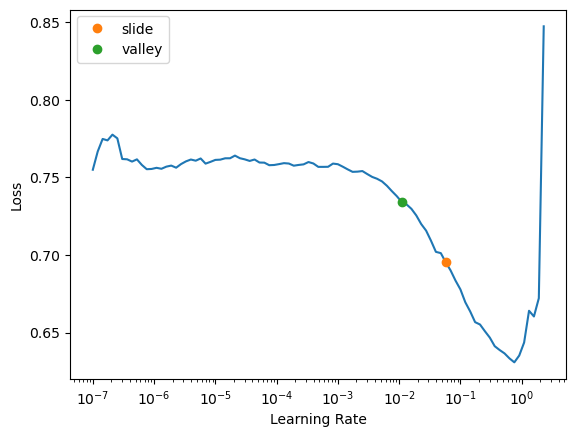

In [34]:
learn.lr_find(suggest_funcs=(slide,valley))

In [37]:
learn.fit(n_epoch=16,lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.560910,0.579823,0.640449,00:00
1,0.478909,0.478465,0.792135,00:00
2,0.454538,0.441145,0.780899,00:00
3,0.446153,0.457196,0.786517,00:00
4,0.444753,0.449864,0.831461,00:00
5,0.439145,0.473063,0.820225,00:00
6,0.432977,0.417260,0.820225,00:00
7,0.428463,0.422700,0.831461,00:00
8,0.421883,0.420225,0.803371,00:00
9,0.414665,0.418329,0.803371,00:00


In [39]:
test_df=pd.read_csv('titanic/test.csv')
test_df['Fare']=test_df.Fare.fillna(0)
add_feature(test_df)

In [40]:
test_dl=learn.dls.test_dl(test_df)

In [41]:
test_dl

In [43]:
pred,_=learn.get_preds(dl=test_dl)

In [51]:
test_df['Survived']=(pred[:,1]>0.5).int()
sub_df=test_df[['PassengerId','Survived']]


In [54]:
sub_df.to_csv('my_sub.csv',index=False)

In [55]:
!ls

ens_sub.csv                          sub.csv
intro_kaggle_comp_c_5.ipynb          titanic
models                               titanic.zip
my_sub.csv                           why-you-should-use-a-framework.ipynb


In [56]:
!head my_sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1
